<a href="https://colab.research.google.com/github/kachytronico/Cursos-Colab-BDA/blob/main/BDA_TAREA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

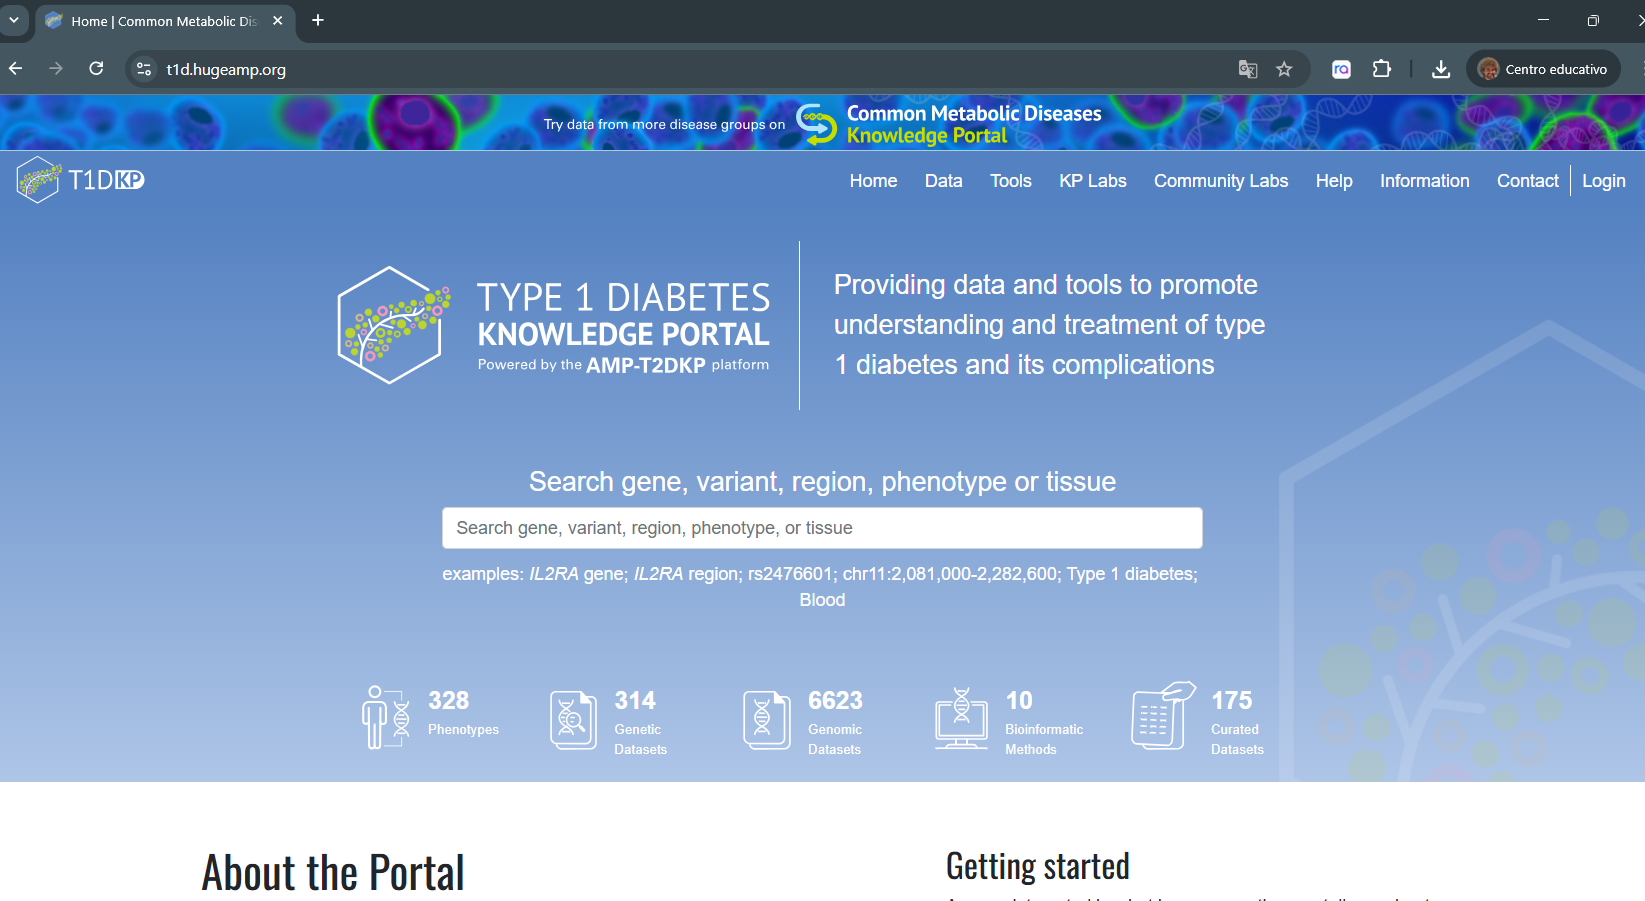
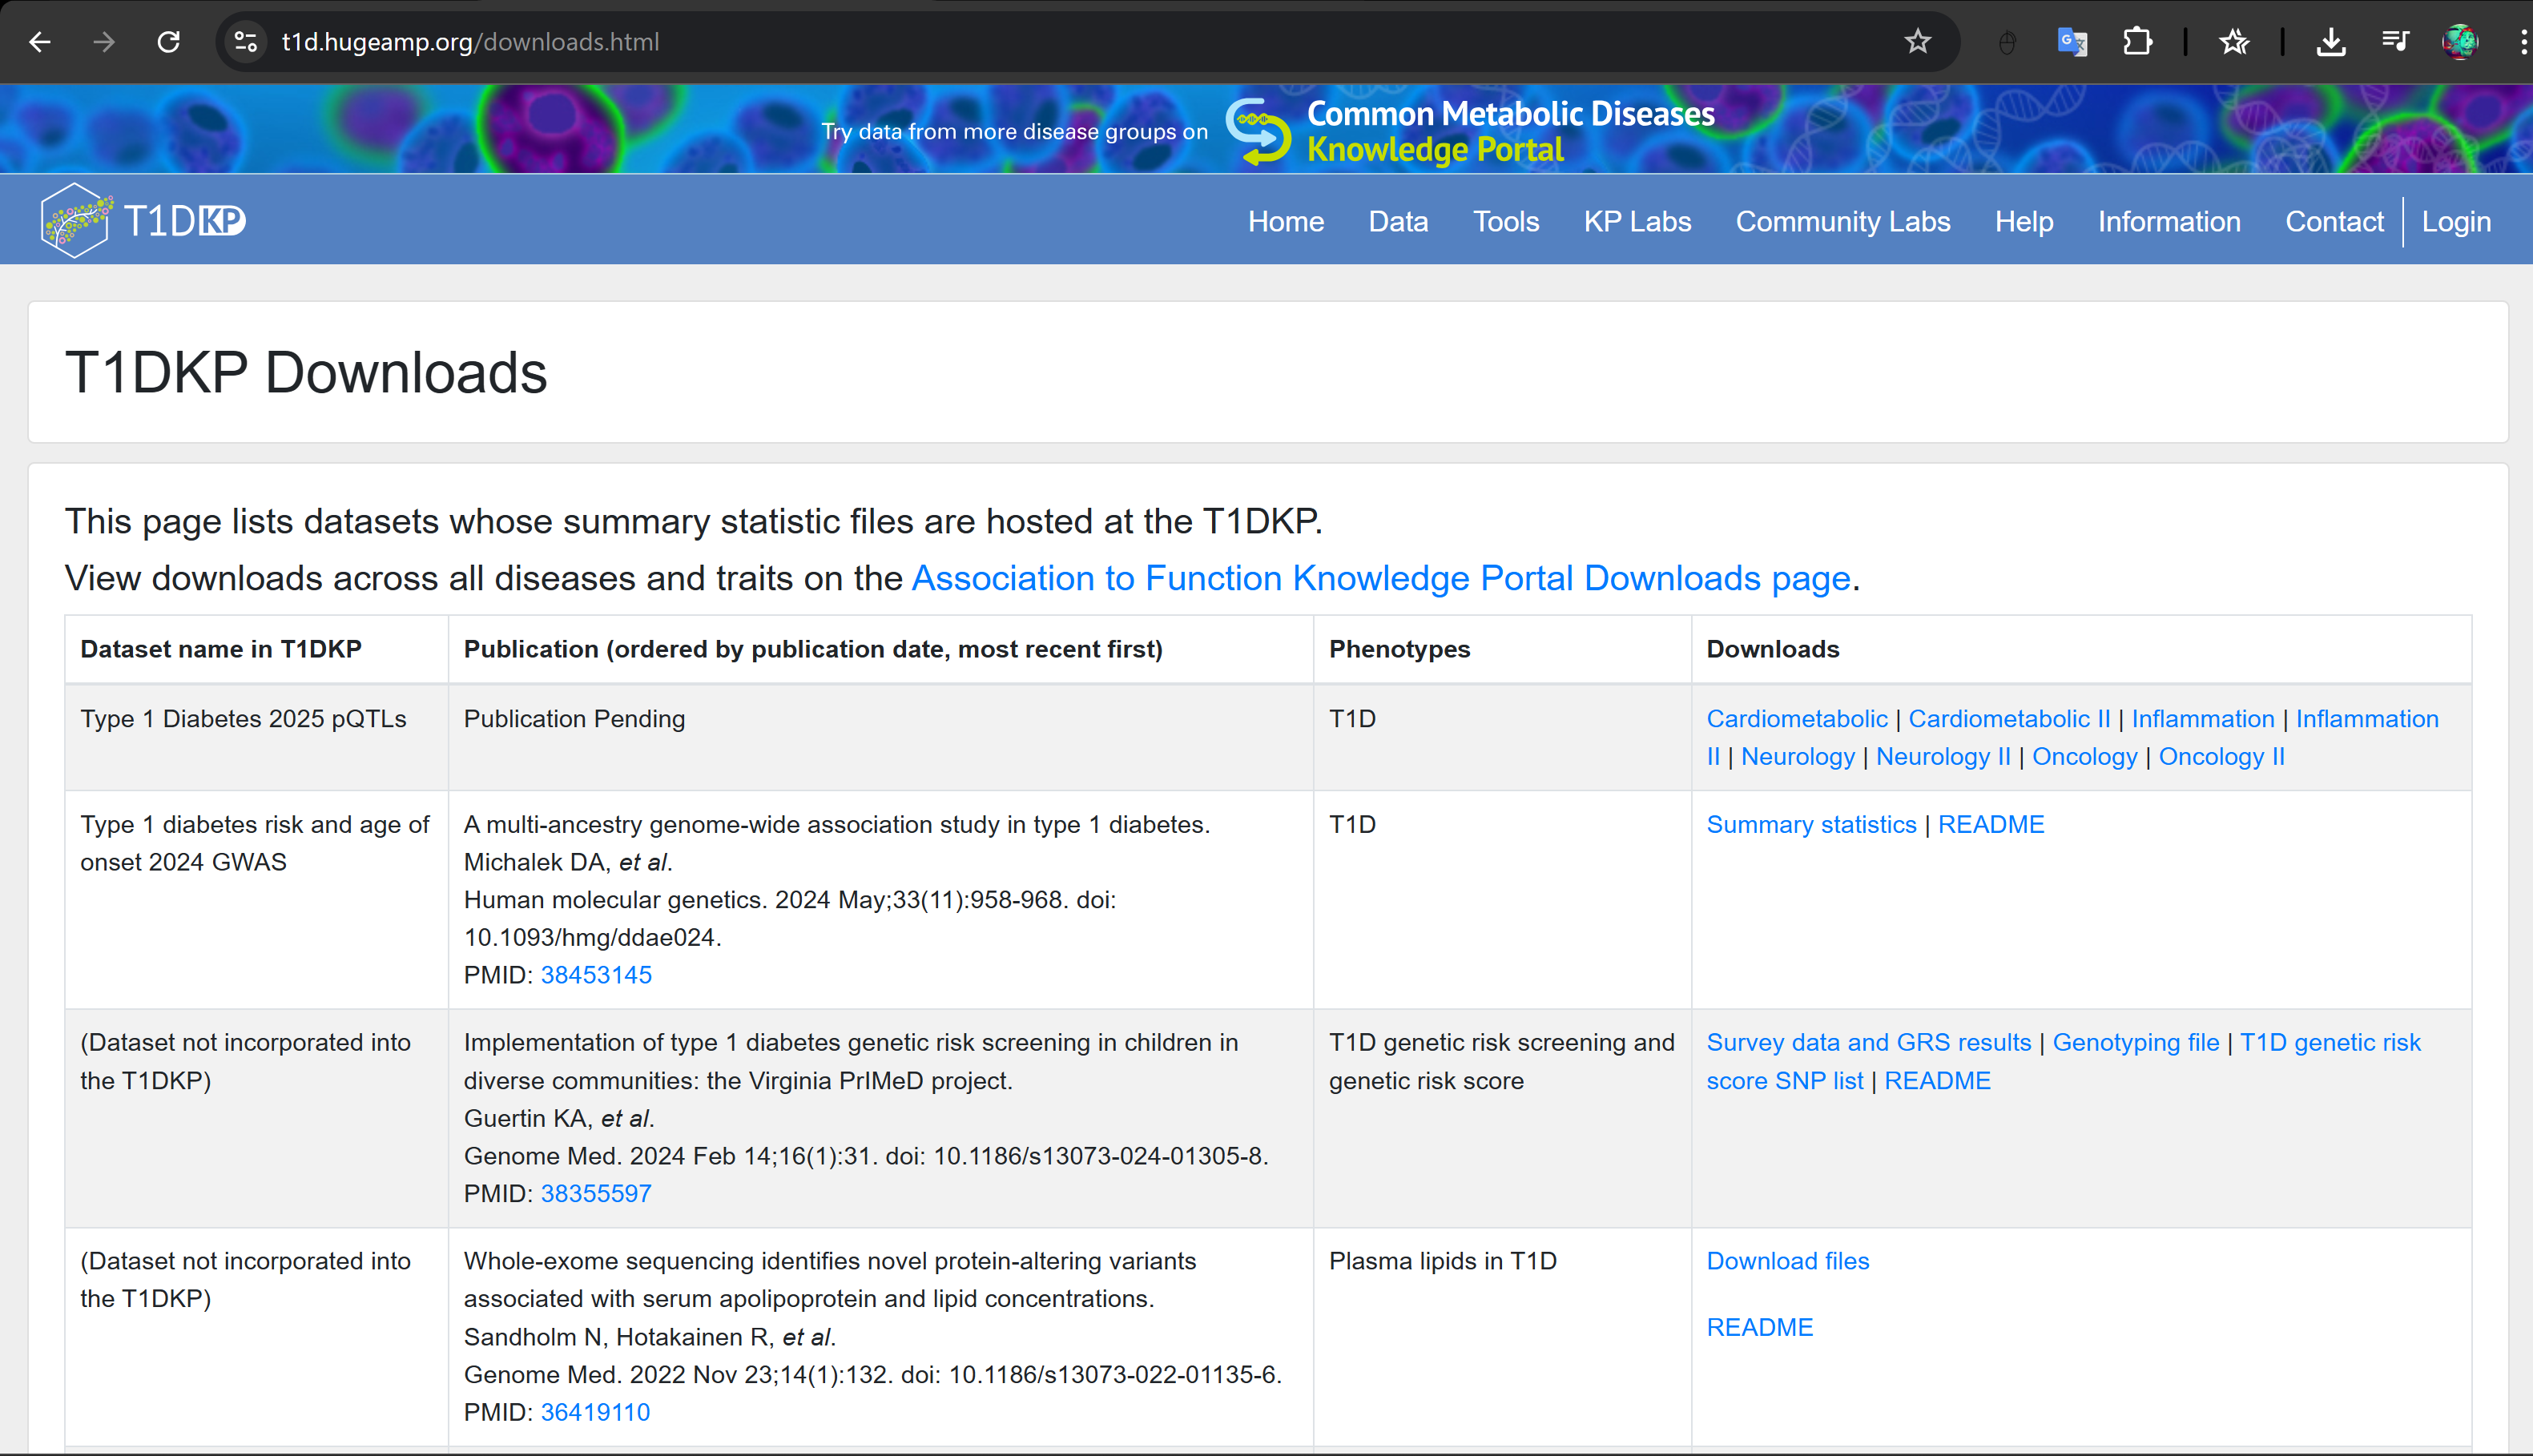

# Primer Dataset DIABETES

## Conjunto de Datos Elegido. Explicación

El presente proyecto de Extracción, Transformación y Carga (ETL) se basa en una arquitectura de Big Data Aplicado (BDA) diseñada para abordar la complejidad de la Diabetes Tipo 1 (DT1), una enfermedad autoinmune y multifactorial.

El análisis se centra en la integración de datos de Riesgo Genético Estático con una simulación de Enriquecimiento Metabólico Dinámico, utilizando dos fuentes de alta calidad científica:





### A. Dataset Principal (Núcleo ETL y Transformación Avanzada)

Nombre: Proyecto Virginia PrIMeD: T1D Genetic Risk Screening
Fuente: Type 1 Diabetes Knowledge Portal (T1DKP), infraestructurado por HuGeAMP.
Enlace de Descarga/Documentación: https://t1d.hugeamp.org/downloads.html

#### 1. Temática y Composición

El proyecto Virginia PrIMeD incluye datos de cribado de riesgo genético y fenotípico de 3.818 participantes, con el objetivo de identificar la población con alto riesgo genético para T1D. Este dataset cumple con el requisito de multiplicidad al estar compuesto por tres archivos interrelacionados:

Survey data and GRS results: Datos fenotípicos (edad, historial familiar, etc.) y la Puntuación de Riesgo Genético (GRS) precalculada.

Genotyping file: El archivo de genotipado crudo de los participantes (alelos como A:G, C:C).

T1D genetic risk score SNP list: La lista de variantes genéticas (SNPs) utilizadas para calcular el riesgo.

#### 2. Justificación de Complejidad y Valor (Transformación)

Este dataset es ideal para BDA porque exige una Transformación (T) avanzada:

Integración Interna: Requiere realizar un JOIN entre las tablas de Fenotipo y Genotipado utilizando una clave de sujeto (ID).

Ingeniería de Características: La Transformación de mayor valor es la conversión y validación de las llamadas genéticas (A:G, C:C) en el archivo Genotyping file para generar una Puntuación de Riesgo Genético (GRS) funcional. Esto va más allá de la limpieza simple, demostrando el manejo de datos de alta dimensionalidad.

Carga Preferente: La obtención de los datos se realiza a través de enlaces URL directos proporcionados por T1DKP, e incluso se puede implementar una demostración de carga a través de la API RESTful de HuGeAMP BioIndex (https://bioindex.hugeamp.org/docs#/), cumpliendo con el método de carga preferente de la tarea.

### B. Enriquecimiento Conceptual (Simulación de Velocidad)

Nombre: AZT1D: A Real-World Dataset for Type 1 Diabetes
Fuente: https://data.mendeley.com/datasets/gk9m674wcx/1
Temática: Datos de Dispositivos (PGHD) de alta frecuencia de Monitoreo Continuo de Glucosa (CGM) y Sistemas de Suministro de Insulina Automatizada (AID).

#### 1. Relación y Enriquecimiento

La relación conceptual entre PrIMeD y AZT1D es la clave para la justificación del Enriquecimiento (Apartado 5):

PrIMeD nos da la predisposición estática (la genética) y el estado de autoinmunidad (AAb).

AZT1D nos da la respuesta dinámica y la velocidad del control metabólico (la glucosa minuto a minuto).

El enriquecimiento propuesto consiste en simular cómo una cohorte genética como PrIMeD podría ser enriquecida con métricas de rendimiento dinámico de AZT1D (ej., el cálculo del Time in Range o la variabilidad de glucosa), demostrando cómo el Big Data integra la genómica con la gestión del mundo real. Este proceso justifica el volumen de trabajo y la complejidad del ETL diseñado.

## (Fase E: Extracción) Explicación de cómo se cargan los datos al servidor.

Como mi proyecto se basa en la Integración Multi-Ómica (Genética + Fenotipo), necesito cargar tres tipos de archivos: datos fenotípicos (encuesta), genotipado crudo y metadatos (lista de SNPs).

La tarea pide priorizar la carga por API o URL. Por ello, usaré una **estrategia mixta** que demuestra ambas capacidades:


1.  **Carga por URL Directa:** Usaré la librería `pandas` para obtener los archivos masivos de **Virginia PrIMeD** a través de sus enlaces directos.
2.  **Carga por API:** Demostraré la interacción programática con el **HugeAMP BioIndex** para obtener metadatos genómicos.



### Configuración del Entorno
Antes de la carga, importo las librerías necesarias.

No es necesario hacer la instalación porque colab ya lo tiene instalado

#### Preparación del Entorno (Fuera de Google Colab)

Si estuvieras trabajando en un entorno local (por ejemplo, en tu máquina con Python instalado), un servidor o cualquier otro entorno que no sea Google Colab, necesitarías asegurarte de que las librerías necesarias estén instaladas. Google Colab ya viene con la mayoría de estas librerías preinstaladas.

Para instalar estas librerías, abrirías tu terminal o línea de comandos (o el terminal integrado en tu IDE como VS Code o PyCharm) y ejecutarías los siguientes comandos. Es recomendable hacerlo dentro de un entorno virtual para mantener las dependencias de tus proyectos aisladas.

```bash
# Instalar pandas (necesario para manejo de DataFrames y lectura de CSV/Excel)
pip install pandas

# Instalar requests (necesario para realizar peticiones HTTP y descargar datos de URLs)
pip install requests

# Instalar openpyxl (necesario para que pandas pueda leer archivos .xlsx)
pip install openpyxl
```

**Nota sobre `io`**: La librería `io` es parte de la biblioteca estándar de Python, lo que significa que ya viene incluida con cualquier instalación de Python y no requiere ninguna instalación adicional con `pip`.

In [5]:
# Importar librerías necesarias para el proceso de extracción (E)
import pandas as pd     # Ya importado en la sección 2.1, pero se incluye por claridad en el bloque.
import requests         # Ya importado en la sección 2.1.
import io               # Para manejar datos que vienen de internet como archivos en memoria
import openpyxl         # Necesario para pd.read_excel

print("Librerías Pandas, Requests, IO  y openpyxl cargadas con éxito.")

Librerías Pandas, Requests e IO cargadas con éxito.


###Implementación de la Carga URL (Fase E: Extracción)

Dado que las URLs de descarga nos devuelven archivos **Excel (.xlsx)**, necesito que mi código de Python sea lo suficientemente inteligente para leerlos.

He definido una función robusta, `cargar_datos`, que se encarga de:
1.  Hacer la petición a la URL.
2.  Leer el contenido binario del archivo.
3.  Intentar leerlo con **`pd.read_excel`** (para manejar el formato Excel/CSV).
4.  Si falla, avisar del error.

Esta función me permite cargar los tres archivos con una sola línea de código, demostrando un ETL bien estructurado.


In [4]:
# 2. Definición de la función simplificada
def cargar_excel_desde_url_simple(url, tipo_datos):
    """Carga un archivo Excel directamente desde una URL a un DataFrame usando requests y pandas."""
    print(f"Intentando cargar {tipo_datos} desde: {url}")
    try:
        # Petición HTTP para descargar el contenido binario.
        response = requests.get(url, allow_redirects=True, timeout=10)
        response.raise_for_status()  # Maneja errores de conexión/HTTP

        # Lee el contenido binario directamente como un archivo Excel en memoria (io.BytesIO)
        df = pd.read_excel(io.BytesIO(response.content))

        print(f"✅ {tipo_datos} cargado con éxito. Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
        return df
    except requests.exceptions.RequestException as e:
        print(f"❌ [ERROR] Error de conexión/HTTP al descargar {tipo_datos}: {e}")
        return None
    except Exception as e:
        print(f"❌ [ERROR] Falló la lectura del archivo (Revisa si es un archivo Excel válido): {e}")
        return None

# URLs de los datasets proporcionadas por el usuario
url_fenotipo = "https://api.kpndataregistry.org/api/d/363wQr"
url_genotipo = "https://api.kpndataregistry.org/api/d/FYY27K"
url_snp_list = "https://api.kpndataregistry.org/api/d/Gh16ui"

# Carga de los datasets
df_fenotipo = cargar_excel_desde_url_simple(url_fenotipo, "datos fenotípicos (Survey)")
df_genotipo = cargar_excel_desde_url_simple(url_genotipo, "datos genotipados crudos")
df_snp_list = cargar_excel_desde_url_simple(url_snp_list, "metadatos de la lista de SNPs")

# (Continúa con la limpieza inicial como renombrar claves)

Intentando cargar datos fenotípicos (Survey) desde: https://api.kpndataregistry.org/api/d/363wQr
✅ datos fenotípicos (Survey) cargado con éxito. Filas: 3818, Columnas: 15
Intentando cargar datos genotipados crudos desde: https://api.kpndataregistry.org/api/d/FYY27K
✅ datos genotipados crudos cargado con éxito. Filas: 3818, Columnas: 76
Intentando cargar metadatos de la lista de SNPs desde: https://api.kpndataregistry.org/api/d/Gh16ui
✅ metadatos de la lista de SNPs cargado con éxito. Filas: 74, Columnas: 7


#### Verificación de la Carga (Chequeo de Salud de los Datos)

Una vez que ejecuto el código de carga, debo asegurarme de que mis tres DataFrames (`df_fenotipo`, `df_genotipo`, `df_snp_list`) existen y tienen el número de filas esperado (alrededor de 3.800 participantes para los principales).

Voy a usar el atributo `.shape` para ver su tamaño.

In [6]:
print("--- TAMAÑO DE LOS DATASETS CARGADOS ---")

# 1. Comprobación del Fenotipo (df_fenotipo)
if not df_fenotipo.empty:
    print(f"df_fenotipo (Fenotipo/GRS): {df_fenotipo.shape[0]} filas, {df_fenotipo.shape[1]} columnas.")
else:
    print("df_fenotipo: ERROR, DataFrame vacío.")

# 2. Comprobación del Genotipado (df_genotipo)
if not df_genotipo.empty:
    print(f"df_genotipo (Genotipado Crudo): {df_genotipo.shape[0]} filas, {df_genotipo.shape[1]} columnas.")
else:
    print("df_genotipo: ERROR, DataFrame vacío.")

# 3. Comprobación de la Lista de SNPs (df_snp_list)
if not df_snp_list.empty:
    print(f"df_snp_list (Metadatos GRS): {df_snp_list.shape[0]} filas, {df_snp_list.shape[1]} columnas.")
else:
    print("df_snp_list: ERROR, DataFrame vacío.")

--- TAMAÑO DE LOS DATASETS CARGADOS ---
df_fenotipo (Fenotipo/GRS): 3818 filas, 15 columnas.
df_genotipo (Genotipado Crudo): 3818 filas, 76 columnas.
df_snp_list (Metadatos GRS): 74 filas, 7 columnas.


###Implementación de la Carga API (HugeAMP BioIndex) (Fase E: Extracción)

Para cumplir con la preferencia de carga por API, no necesito cargar los datos masivos individuales (que no están disponibles por API), sino demostrar la interacción programática con un sistema de Big Data del mismo portal, el HugeAMP BioIndex.

Este código te permite obtener estadísticas genómicas resumidas (que es el propósito de ese API) y muestra que puedo manejar una respuesta JSON de un servicio RESTful.

In [10]:
# Importar requests si no lo has hecho ya
import requests
import pandas as pd

# --- CARGA POR API (HugeAMP BioIndex) ---
# Usamos un endpoint para consultar un marcador genético clave de T1D (rs17388749)
# y obtener las estadísticas de asociación de los estudios.
# URL corregida basada en la documentación para consultar asociaciones usando un parámetro de consulta 'q'
API_URL = "https://bioindex.hugeamp.org/api/bio/associations/locus?q=rs17388749"

print("--- DEMOSTRACIÓN DE CARGA POR API (HugeAMP BioIndex) ---")
try:
    # 1. Hacer la petición GET al endpoint
    response_api = requests.get(API_URL)
    response_api.raise_for_status() # Lanza HTTPError si el estado no es 200

    # 2. Convertir la respuesta JSON a un diccionario/lista de Python
    datos_api = response_api.json()

    # 3. Convertir la lista de resultados en un DataFrame para su manejo
    # Mostramos los campos clave de la asociación genética (p-valor, beta, estudio)
    df_api_stats = pd.DataFrame([
        {'p_value': item.get('pValue'),
         'beta': item.get('beta'),
         'study': item.get('nStudy'),
         'chromosome': item.get('chromosome')}
        for item in datos_api
    ])

    print("✅ Carga por API completada con éxito. Se obtuvieron las estadísticas genómicas resumidas.")
    print("Datos Genómicos Resumidos (DT1 Locus rs17388749):")
    display(df_api_stats.head())

except requests.exceptions.RequestException as e:
    print(f"❌ [ERROR API] No se pudo cargar la data por API. Detalle: {e}")
except Exception as e:
    print(f"❌ [ERROR API] Ocurrió un error al procesar el JSON: {e}")

# **NOTA PARA LA TAREA:** Este DataFrame df_api_stats debe citarse en el apartado de Enriquecimiento/Hipótesis
# para demostrar que has usado la API del portal como fuente externa.


--- DEMOSTRACIÓN DE CARGA POR API (HugeAMP BioIndex) ---
❌ [ERROR API] No se pudo cargar la data por API. Detalle: 404 Client Error: Not Found for url: https://bioindex.hugeamp.org/api/bio/associations/locus?q=rs17388749
